# FashionMNIST - linear model

In [ ]:
! pip install torchinfo

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split, Subset
import torchvision.transforms as transforms

import torchvision

from numpy.random import seed
import torch
import numpy as np

from torchinfo import summary
import matplotlib.pyplot as plt

In [ ]:
# Load dataset

train_dataset = torchvision.datasets.FashionMNIST('./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.FashionMNIST('./data',
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download=True)

/Users/rliu/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Randomly select 6000 for training

N = len(train_dataset)
train_dataset = Subset(train_dataset, np.random.choice(N, 6000, replace=False))

In [ ]:
# Split dataset into training and evaluation

N = len(train_dataset)
train_size = int(0.7*N)
train_dataset, val_dataset = random_split(train_dataset,\
                                          lengths=[train_size, N - train_size])

print(f'Train dataset length: {len(train_dataset)}')
print(f'Validation dataset length: {len(val_dataset)}')


Train dataset length: 4200
Validation dataset length: 1800


image tensor: torch.Size([32, 1, 28, 28])
class labels: tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8])


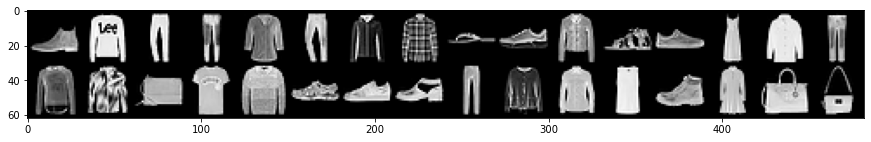

In [ ]:
# Show some images from test dataset

batch_size = 32

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
imgs, labels = next(iter(test_loader))
plt.figure(figsize=(15,10))
grid = torchvision.utils.make_grid(nrow=16, ncols=2, tensor=imgs)
print(f"image tensor: {imgs.shape}")
print(f"class labels: {labels}")
plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');

In [ ]:
# Fix random number so that your traing process can be replicated

random_seed = 124
seed(random_seed)

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [ ]:
class linear_model(nn.Module):
    
    # hidden_units is a list which specify the output of each layer
    def __init__(self, input_dim = 784, hidden_units=[256]):
        
        # initialize parent class
        super(linear_model, self).__init__()
        
        hidden_units = [input_dim] + hidden_units
        
        self.layers = nn.ModuleList([nn.Linear(hidden_units[i], hidden_units[i+1]) \
                                     for i in range(len(hidden_units)-1)])
    
    def forward(self, x):
        
        output = x
        #print(x.size())
        for i, layer in enumerate(self.layers):
            
            output = layer(output)
            #print(output.size())
            
            if i<len(self.layers)-1:   # no activation on the last layer
                output = F.relu(output)
        
        return output

In [ ]:
def train_model(model, train_dataset, val_dataset, test_dataset, device, 
                optimizer, epochs=30, batch_size=128):
    
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}

    # setup loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        for x, y in train_loader:
            
            # move data to device
            x = x.view(x.size(0), -1).to(device)
            y = y.to(device)
            
            # forward
            outputs = model(x)  # (num_batch, 45) 
            _, pred = torch.max(outputs, dim = -1)
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = (pred == y).sum().item() / y.size(0)
            
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in val_loader:
                # move
                x = x.view(x.size(0), -1).to(device)
                y = y.to(device)
                
                # predict
                outputs = model(x)
                _, pred = torch.max(outputs, dim = -1)
                cur_val_loss = criterion(outputs, y)
                cur_val_acc = (pred == y).sum().item() / y.size(0) 
                
                # loss and acc
                val_loss += cur_val_loss
                val_acc += cur_val_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (val_loss/len(val_loader)).item()
        val_acc = val_acc/len(val_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.3f} train_acc:{train_acc:.3f}, valid loss:{val_loss:.3f} valid acc:{val_acc:.3f}")
    
    # Test performance
    model.eval()
    ys = []
    preds = []

    with torch.no_grad():
        for x, y in test_loader:
            # move
            x = x.view(x.size(0), -1).to(device)

            # predict
            outputs = model(x)
            _, pred = torch.max(outputs, dim = -1)

            preds.append(pred.view(-1).cpu().numpy())
            ys.append(y)

    ys = np.concatenate(ys)
    preds = np.concatenate(preds)

    test_acc = (ys==preds).astype(int).sum()/len(ys)
    print(f"test acc:{test_acc:.3f}")

    return test_acc, history

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# dataset

modela = linear_model(input_dim = 784, hidden_units=[64,  10])
summary(modela, (32, 784))

optimizer = torch.optim.RMSprop(modela.parameters(), lr = 0.0005)
acc_a, hista = train_model(modela, train_dataset, val_dataset, test_dataset, device, optimizer, epochs=100)

Layer (type:depth-idx)                   Output Shape              Param #
linear_model                             --                        --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [32, 64]                  50,240
│    └─Linear: 2-2                       [32, 10]                  650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (M): 1.63
Input size (MB): 0.10
Forward/backward pass size (MB): 0.02
Params size (MB): 0.20
Estimated Total Size (MB): 0.32

Training Start
Epoch:1 / 100, train loss:1.228 train_acc:0.604, valid loss:0.859 valid acc:0.713
Epoch:2 / 100, train loss:0.822 train_acc:0.728, valid loss:0.744 valid acc:0.736
Epoch:3 / 100, train loss:0.735 train_acc:0.754, valid loss:0.671 valid acc:0.786
Epoch:4 / 100, train loss:0.677 train_acc:0.771, valid loss:0.629 valid acc:0.793
Epoch:5 / 100, train loss:0.642 train_acc:0.781, valid loss:0.612 valid acc:0.778
Epoch:6 / 100, train loss:0.614 train_acc:0.791, valid loss:0.594 valid acc:0.772
Epoch:7 / 100, train loss:0.591 train_acc:0.804, valid loss:0.572 valid acc:0.786
Epoch:8 / 100, train loss:0.570 train_acc:0.809, valid loss:0.556 valid acc:0.794
Epoch:9 / 100, train loss:0.554 train_acc:0.816, valid loss:0.541 valid acc:0.808
Epoch:10 / 100, train loss:0.535 train_acc:0.826, valid loss:0.532 valid acc:0.811
Epoch:11 / 100, train loss:0.526 train_acc:0.821, valid loss:0.532 valid acc:0.811
Epoch:12 / 100, train loss:0.511 train_acc:0.831, valid loss:0.523 valid acc:0.81

In [ ]:
# dataset

modelb = linear_model(input_dim = 784, hidden_units=[512,  10])
summary(modelb, (32, 784))

optimizer = torch.optim.RMSprop(modelb.parameters(), lr = 0.0005)
acc_b, histb = train_model(modelb, train_dataset, val_dataset, test_dataset, device, optimizer, epochs = 100)

Layer (type:depth-idx)                   Output Shape              Param #
linear_model                             --                        --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [32, 512]                 401,920
│    └─Linear: 2-2                       [32, 10]                  5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
Total mult-adds (M): 13.03
Input size (MB): 0.10
Forward/backward pass size (MB): 0.13
Params size (MB): 1.63
Estimated Total Size (MB): 1.86

Training Start
Epoch:1 / 100, train loss:1.086 train_acc:0.617, valid loss:0.739 valid acc:0.724
Epoch:2 / 100, train loss:0.702 train_acc:0.753, valid loss:0.631 valid acc:0.767
Epoch:3 / 100, train loss:0.623 train_acc:0.782, valid loss:0.607 valid acc:0.776
Epoch:4 / 100, train loss:0.566 train_acc:0.807, valid loss:0.558 valid acc:0.789
Epoch:5 / 100, train loss:0.538 train_acc:0.814, valid loss:0.559 valid acc:0.785
Epoch:6 / 100, train loss:0.518 train_acc:0.817, valid loss:0.565 valid acc:0.789
Epoch:7 / 100, train loss:0.487 train_acc:0.828, valid loss:0.527 valid acc:0.803
Epoch:8 / 100, train loss:0.470 train_acc:0.837, valid loss:0.496 valid acc:0.814
Epoch:9 / 100, train loss:0.452 train_acc:0.845, valid loss:0.495 valid acc:0.804
Epoch:10 / 100, train loss:0.436 train_acc:0.854, valid loss:0.471 valid acc:0.832
Epoch:11 / 100, train loss:0.417 train_acc:0.859, valid loss:0.461 valid acc:0.829
Epoch:12 / 100, train loss:0.403 train_acc:0.862, valid loss:0.468 valid acc:0.83

In [ ]:
def get_plot(hist_list, labels, epochs):
    
    colors = ['red',"blue","green","orange"]
    
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    for i, hist in enumerate(hist_list):
        ax[0].plot(range(len(hist['val_loss'])), hist['val_loss'], '-', color = colors[i], label=labels[i])
        
    ax[0].set_title('Evaluation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    for i, hist in enumerate(hist_list):
        ax[1].plot(range(len(hist['val_acc'])), hist['val_acc'], '-', color = colors[i], label=labels[i])
        

    ax[1].set_title('Evaluation Acc.')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Acc.')
    ax[1].legend()
   
    plt.show()

Test acc: model A 0.834, model B 0.846


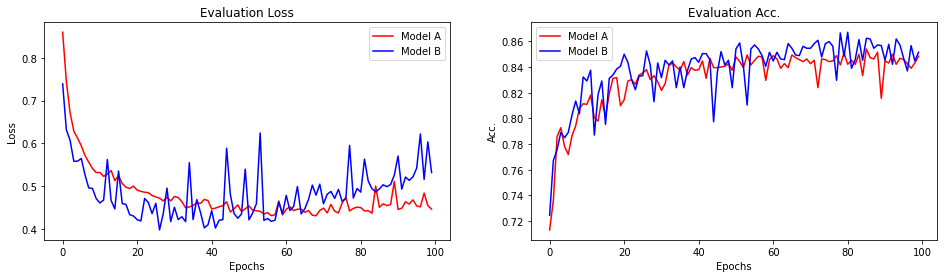

In [ ]:
print(f"Test acc: model A {acc_a:.3f}, model B {acc_b:.3f}")

get_plot([hista, histb], ["Model A","Model B"], len(hista['val_loss']))

## Overfitting using Dropout 

In [ ]:
class linear_model_with_dropout(nn.Module):
    
    # hidden_units is a list which specify the output of each layer
    def __init__(self, input_dim = 784, hidden_units=[100], droprate=0.3):
        
        # initialize parent class
        super(linear_model_with_dropout, self).__init__()
        
        hidden_units = [input_dim] + hidden_units
        
        self.layers = nn.ModuleList([nn.Linear(hidden_units[i], hidden_units[i+1]) for i in range(len(hidden_units)-1)])
        
        self.dropout = nn.Dropout(droprate)
    
    def forward(self, x):
        
        output = self.dropout(x)
        for i, layer in enumerate(self.layers):
            
            output = layer(output)
            
            if i<len(self.layers)-1:   # no activation on the last layer
                output = F.relu(output)
                output = self.dropout(output)
        
        return output

In [ ]:
# dataset

modelc = linear_model_with_dropout(input_dim = 784, 
                                   hidden_units=[512, 10],
                                  droprate = 0.3)
summary(modelc, (24, 784))

optimizer = torch.optim.RMSprop(modelc.parameters(), lr = 0.0005)

acc_c, histc = train_model(modelc, train_dataset, val_dataset, test_dataset, 
                     device, optimizer, epochs = 100)

Layer (type:depth-idx)                   Output Shape              Param #
linear_model_with_dropout                --                        --
├─ModuleList: 1-1                        --                        --
├─Dropout: 1-2                           [24, 784]                 --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [24, 512]                 401,920
├─Dropout: 1-3                           [24, 512]                 --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-2                       [24, 10]                  5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
Total mult-adds (M): 9.77
Input size (MB): 0.08
Forward/backward pass size (MB): 0.10
Params size (MB): 1.63
Estimated Total Size (MB): 1.80

Training Start
Epoch:1 / 100, train loss:1.110 train_acc:0.615, valid loss:0.712 valid acc:0.757
Epoch:2 / 100, train loss:0.744 train_acc:0.727, valid loss:0.629 valid acc:0.785
Epoch:3 / 100, train loss:0.663 train_acc:0.766, valid loss:0.603 valid acc:0.777
Epoch:4 / 100, train loss:0.621 train_acc:0.790, valid loss:0.551 valid acc:0.785
Epoch:5 / 100, train loss:0.590 train_acc:0.793, valid loss:0.542 valid acc:0.800
Epoch:6 / 100, train loss:0.563 train_acc:0.802, valid loss:0.521 valid acc:0.808
Epoch:7 / 100, train loss:0.551 train_acc:0.804, valid loss:0.504 valid acc:0.818
Epoch:8 / 100, train loss:0.538 train_acc:0.808, valid loss:0.497 valid acc:0.820
Epoch:9 / 100, train loss:0.514 train_acc:0.823, valid loss:0.490 valid acc:0.827
Epoch:10 / 100, train loss:0.512 train_acc:0.819, valid loss:0.477 valid acc:0.829
Epoch:11 / 100, train loss:0.502 train_acc:0.814, valid loss:0.466 valid acc:0.834
Epoch:12 / 100, train loss:0.487 train_acc:0.831, valid loss:0.479 valid acc:0.82

Test acc: model A 0.834, model B 0.846, model C 0.855


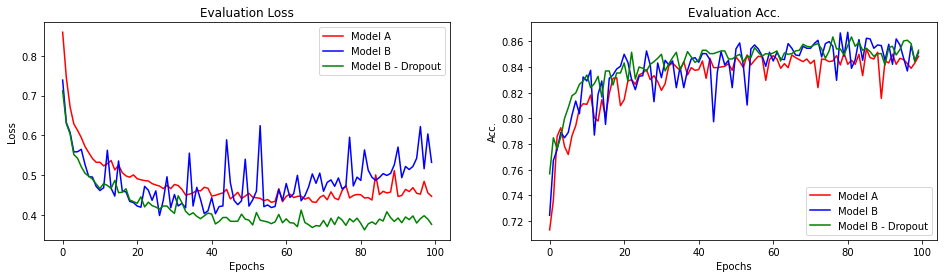

In [ ]:
print(f"Test acc: model A {acc_a:.3f}, model B {acc_b:.3f}, model C {acc_c:.3f}")

get_plot([hista, histb, histc], ["Model A","Model B", "Model B - Dropout"], len(hista['val_loss']))

## Optimizer :   SGD / Adagrad / RMSProp / Adam

In [ ]:
# SGD
modelx = linear_model(input_dim = 784, hidden_units=[512,  10])
summary(modelx, (32, 784))

optimizer = torch.optim.SGD(modelx.parameters(), lr=0.0005)

acc_d, histd = train_model(modelx, train_dataset, val_dataset, test_dataset, device, optimizer, epochs=100)


Layer (type:depth-idx)                   Output Shape              Param #
linear_model                             --                        --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [32, 512]                 401,920
│    └─Linear: 2-2                       [32, 10]                  5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
Total mult-adds (M): 13.03
Input size (MB): 0.10
Forward/backward pass size (MB): 0.13
Params size (MB): 1.63
Estimated Total Size (MB): 1.86

Training Start
Epoch:1 / 100, train loss:2.30438 train_acc:0.091, valid loss:2.292 valid acc:0.129
Epoch:2 / 100, train loss:2.29212 train_acc:0.127, valid loss:2.280 valid acc:0.173
Epoch:3 / 100, train loss:2.28011 train_acc:0.169, valid loss:2.268 valid acc:0.204
Epoch:4 / 100, train loss:2.26856 train_acc:0.201, valid loss:2.257 valid acc:0.227
Epoch:5 / 100, train loss:2.25732 train_acc:0.224, valid loss:2.246 valid acc:0.244
Epoch:6 / 100, train loss:2.24651 train_acc:0.242, valid loss:2.235 valid acc:0.266
Epoch:7 / 100, train loss:2.23576 train_acc:0.260, valid loss:2.224 valid acc:0.282
Epoch:8 / 100, train loss:2.22532 train_acc:0.274, valid loss:2.214 valid acc:0.292
Epoch:9 / 100, train loss:2.21509 train_acc:0.288, valid loss:2.204 valid acc:0.309
Epoch:10 / 100, train loss:2.20501 train_acc:0.300, valid loss:2.194 valid acc:0.319
Epoch:11 / 100, train loss:2.19510 train_acc:0.310, valid loss:2.184 valid acc:0.331
Epoch:12 / 100, train loss:2.18544 train_acc:0.323, valid l

In [ ]:
# Adaptive learn
modelx = linear_model(input_dim = 784, hidden_units=[512,  10])
summary(modelx, (32, 784))

optimizer = torch.optim.Adagrad(modelx.parameters(), lr=0.0005)

acc_e, histe = train_model(modelx, train_dataset, val_dataset, test_dataset, device, optimizer, epochs=100)


Layer (type:depth-idx)                   Output Shape              Param #
linear_model                             --                        --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [32, 512]                 401,920
│    └─Linear: 2-2                       [32, 10]                  5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
Total mult-adds (M): 13.03
Input size (MB): 0.10
Forward/backward pass size (MB): 0.13
Params size (MB): 1.63
Estimated Total Size (MB): 1.86

Training Start
Epoch:1 / 100, train loss:1.71792 train_acc:0.556, valid loss:1.404 valid acc:0.661
Epoch:2 / 100, train loss:1.27773 train_acc:0.656, valid loss:1.168 valid acc:0.676
Epoch:3 / 100, train loss:1.10987 train_acc:0.676, valid loss:1.044 valid acc:0.682
Epoch:4 / 100, train loss:1.01749 train_acc:0.688, valid loss:0.974 valid acc:0.695
Epoch:5 / 100, train loss:0.95529 train_acc:0.700, valid loss:0.926 valid acc:0.710
Epoch:6 / 100, train loss:0.91052 train_acc:0.714, valid loss:0.883 valid acc:0.716
Epoch:7 / 100, train loss:0.87627 train_acc:0.724, valid loss:0.853 valid acc:0.723
Epoch:8 / 100, train loss:0.84870 train_acc:0.729, valid loss:0.826 valid acc:0.735
Epoch:9 / 100, train loss:0.82646 train_acc:0.739, valid loss:0.807 valid acc:0.741
Epoch:10 / 100, train loss:0.80581 train_acc:0.746, valid loss:0.787 valid acc:0.745
Epoch:11 / 100, train loss:0.78855 train_acc:0.752, valid loss:0.770 valid acc:0.762
Epoch:12 / 100, train loss:0.77480 train_acc:0.756, valid l

In [ ]:
# Adam

modelx = linear_model(input_dim = 784, hidden_units=[512,  10])
summary(modelx, (32, 784))

optimizer = torch.optim.Adam(modelx.parameters(), lr=0.0005)

acc_f, histf = train_model(modelx, train_dataset, val_dataset, test_dataset, device, optimizer, epochs=100)


Layer (type:depth-idx)                   Output Shape              Param #
linear_model                             --                        --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [32, 512]                 401,920
│    └─Linear: 2-2                       [32, 10]                  5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
Total mult-adds (M): 13.03
Input size (MB): 0.10
Forward/backward pass size (MB): 0.13
Params size (MB): 1.63
Estimated Total Size (MB): 1.86

Training Start
Epoch:1 / 100, train loss:1.34429 train_acc:0.593, valid loss:0.833 valid acc:0.706
Epoch:2 / 100, train loss:0.76821 train_acc:0.733, valid loss:0.672 valid acc:0.767
Epoch:3 / 100, train loss:0.64523 train_acc:0.782, valid loss:0.601 valid acc:0.795
Epoch:4 / 100, train loss:0.57828 train_acc:0.798, valid loss:0.577 valid acc:0.798
Epoch:5 / 100, train loss:0.52984 train_acc:0.821, valid loss:0.519 valid acc:0.822
Epoch:6 / 100, train loss:0.50169 train_acc:0.830, valid loss:0.505 valid acc:0.834
Epoch:7 / 100, train loss:0.47351 train_acc:0.844, valid loss:0.527 valid acc:0.810
Epoch:8 / 100, train loss:0.45415 train_acc:0.847, valid loss:0.477 valid acc:0.829
Epoch:9 / 100, train loss:0.43437 train_acc:0.849, valid loss:0.498 valid acc:0.824
Epoch:10 / 100, train loss:0.42055 train_acc:0.855, valid loss:0.467 valid acc:0.836
Epoch:11 / 100, train loss:0.41622 train_acc:0.859, valid loss:0.470 valid acc:0.833
Epoch:12 / 100, train loss:0.38816 train_acc:0.866, valid l

Test acc: SGD 0.640, Adagrad 0.810, RMSprop 0.845, Adam 0.841 


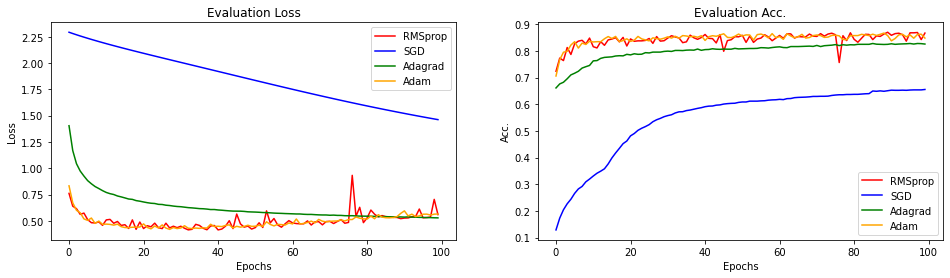

In [ ]:
#plot

print(f"Test acc: SGD {acc_d:.3f}, Adagrad {acc_e:.3f}, RMSprop {acc_b:.3f}, Adam {acc_f:.3f} ")

get_plot([histb, histd, histe, histf], ["RMSprop", "SGD", 'Adagrad','Adam'], len(histb['val_loss']))